# 1. Introduction

###### We are going to compare the following algorithms:
###### 1). Autoencoder 
###### 2). One-Class SVM 
###### 3). Isolation Forest 
###### 4). Local Outlier Factor 

In [3]:
# you can run this code in you terminal to create virtual environment
# python -m venv Anomaly

In [4]:
# then activate your virtual environment
# Anomaly\Scripts\Activate.ps1

In [5]:
#you may also want to upgrade your pip by running this code
# python.exe -m pip install --upgrade pip

In [6]:
# Now put all your packages in the requirements.txt file and run it using this codeee
# pip3 install -r requirements.txt

In [77]:
# Now import your packages 
# Synthetic dataset
from sklearn.datasets import make_classification

#Data processing
import pandas as pd
import numpy as np
from collections import Counter

#Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.lines as mlines
from sklearn.inspection import DecisionBoundaryDisplay
import seaborn as sns

#Model and performance
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn import metrics

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# for autoencoder
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




In [9]:
''' 
generate the data to be used for the anomaly detection. 
Generate a dataset with 1000 samples, 2 features, and a 99% to 1% class imbalance
X contains the feature data, y contains the labels (0 for normal, 1 for anomaly)
'''
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,n_repeated=0, weights=[0.99, 0.01], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
# confirm the class distribution
print(np.unique(y))
print(np.sum(y==0))
print(np.sum(y==1))

[0 1]
984
16


##### Now that we have our data set up, let's start fitting the models one by one

# 2). Autoencoder

#### Autoencoder is a bottle-neck type neural network that learns a compressed representation of the data by projecting it
#### down to a lower dimension.
#### Autoencoders are trained on normal data to learn the representation of the normal state. During inference, 
#### if an input significantly deviates from this learned representation, the AutoEncoder will likely reconstruct it poorly. 
#### and this poor reconstruction is a signal of an anomaly.

In [29]:
# since autoencoder is trained on normal data points, let isolate those
X_train_genuine = X_train[y_train == 0]
X_test_genuine = X_test[y_test==0]

X_train_anomaly = X_train[y_train==1]
X_test_anomaly = X_test[y_test==1]
print(X_train_genuine.shape)
print(X_train_anomaly.shape)
print(X_train_genuine[:4,:])

(658, 2)
(12, 2)
[[ 1.88262601 -0.37169182]
 [-0.54395666 -0.43555512]
 [-1.32338835 -2.12350652]
 [ 1.01923147 -1.21898021]]


In [30]:
# here is the encoder, to create the bottle-neck we use 64,32,16 layers and reconstruct the compression using 16,32, and 64.
CODE_DIM = 2
INPUT_SHAPE = X_train.shape[1]
input_layer = Input(shape=(INPUT_SHAPE,))
x = Dense(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
code = Dense(CODE_DIM, activation='relu')(x)
x = Dense(16, activation='relu')(code)
x = Dense(32, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(INPUT_SHAPE, activation='relu')(x)
autoencoder = Model(input_layer, output_layer, name='anomaly')

In [31]:
# here is the training parameters
model_name = ".weights.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            save_weights_only=True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

In [32]:
# we compile
autoencoder.compile(loss='mae',
                    optimizer=Adam())

In [33]:
# and then the training
history = autoencoder.fit(X_train_genuine, X_train_genuine,
                          epochs=65, batch_size=64,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks, shuffle=True)

Epoch 1/65
 1/11 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - loss: 1.0813
Epoch 1: val_loss improved from inf to 1.07065, saving model to .weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1.0832 - val_loss: 1.0706
Epoch 2/65
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.0243
Epoch 2: val_loss improved from 1.07065 to 1.02100, saving model to .weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0591 - val_loss: 1.0210
Epoch 3/65
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0563
Epoch 3: val_loss improved from 1.02100 to 0.91111, saving model to .weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0221 - val_loss: 0.9111
Epoch 4/65
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0345
Epoch 4: val_loss improved from 0.91111 to 0.84795, saving model to .weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9296 - val_loss: 0.8479
Epoch 5/65
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7799
Epoch 5: val_loss improved from 0.84795 to 0.84070, saving 

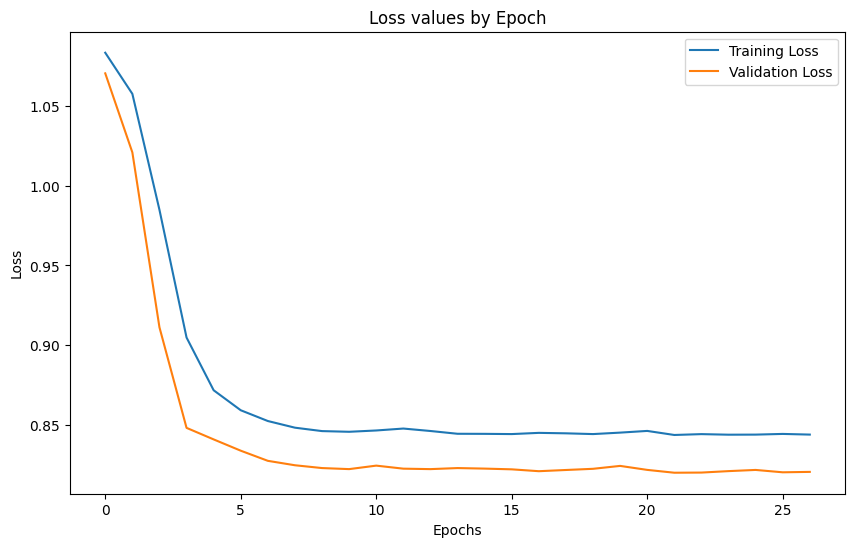

In [34]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [35]:
reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)

In [36]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,1.914204,0
1,0.476507,0
2,0.083374,0
3,0.600990,0
4,0.564427,0


In [37]:
# find threshold 
def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        if i%100 == 0:
          print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

In [38]:
thresh_df = thresholdTuning(recons_df, 1000)

Threshold: 0.0126	Accuracy: 0.015		Precision: 0.506	Recall Score: 0.502
Threshold: 0.3286	Accuracy: 0.106		Precision: 0.490	Recall Score: 0.424
Threshold: 0.4210	Accuracy: 0.206		Precision: 0.498	Recall Score: 0.475
Threshold: 0.4902	Accuracy: 0.300		Precision: 0.494	Recall Score: 0.399
Threshold: 0.5663	Accuracy: 0.394		Precision: 0.491	Recall Score: 0.323
Threshold: 0.6601	Accuracy: 0.494		Precision: 0.494	Recall Score: 0.373
Threshold: 0.7647	Accuracy: 0.594		Precision: 0.496	Recall Score: 0.424
Threshold: 0.9258	Accuracy: 0.694		Precision: 0.499	Recall Score: 0.475
Threshold: 1.2394	Accuracy: 0.794		Precision: 0.502	Recall Score: 0.525
Threshold: 1.6199	Accuracy: 0.888		Precision: 0.493	Recall Score: 0.449


In [39]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 1.353866


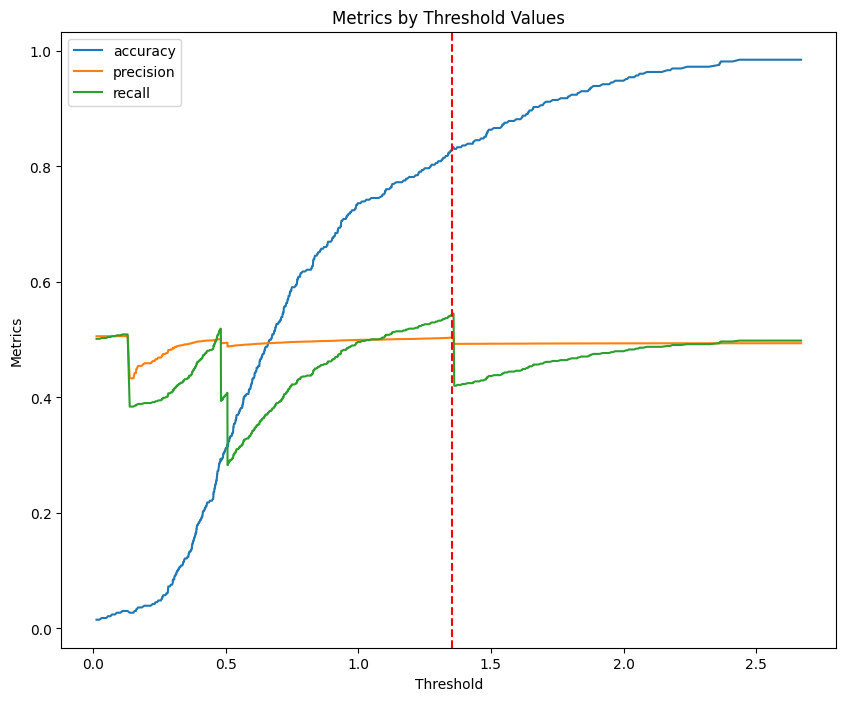

In [40]:
plt.figure(figsize=(10,8))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()

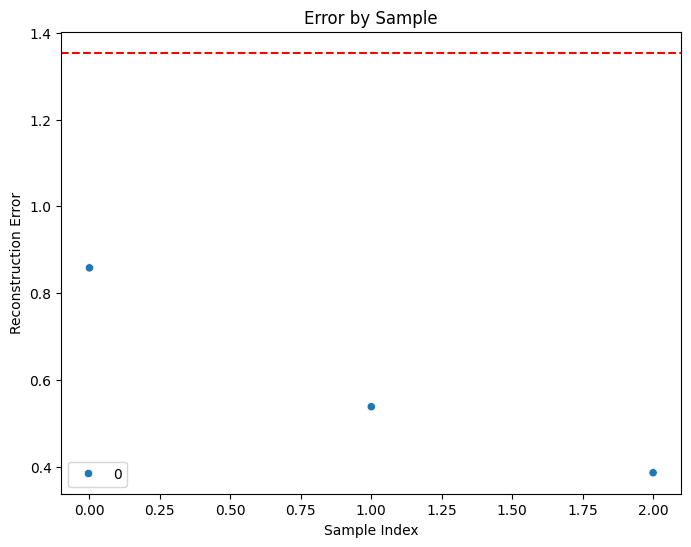

In [41]:
temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Error by Sample')
plt.legend()
plt.show()

In [42]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df.head()

,error,y_true,y_pred
0,1.914204,0,True
1,0.476507,0,False
2,0.083374,0,False
3,0.600990,0,False
4,0.564427,0,False


In [43]:
print(classification_report(recons_df['y_true'],recons_df['y_pred']))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       326
           1       0.02      0.25      0.04         4

    accuracy                           0.83       330
   macro avg       0.50      0.55      0.47       330
weighted avg       0.98      0.83      0.90       330



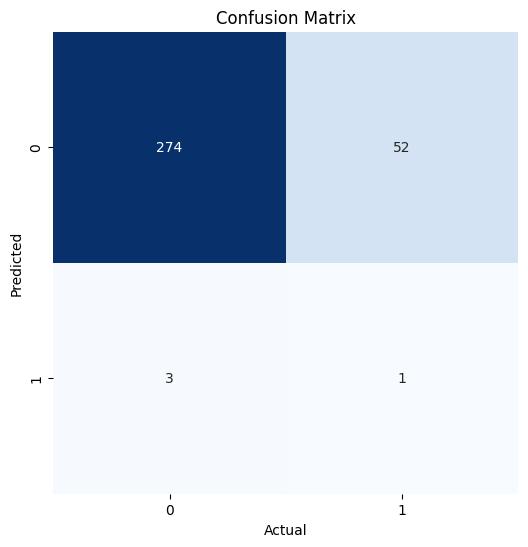

In [44]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [45]:
# Calculate the accuracty and other classification metrics
AE_accuracy = metrics.accuracy_score(recons_df['y_true'], recons_df['y_pred'])*100
AE_precision = metrics.precision_score(recons_df['y_true'], recons_df['y_pred'], average="micro")*100
AE_recall = metrics.recall_score(recons_df['y_true'], recons_df['y_pred'], average="micro")*100
AE_f1score = metrics.f1_score(recons_df['y_true'], recons_df['y_pred'], average="micro")*100
#lr_classification_rep = classification_report(y_test, lr_pred, target_names=data.target_names)

In [46]:

# Lets print the results
print(f"Accuracy: {AE_accuracy:.2f}")
print(f"precision: {AE_precision:.2f}")
print(f"Recall: {AE_recall:.2f}")
print(f"F1Score: {AE_f1score:.2f}")
#print(f"Classification Report:")
#print(lr_classification_rep)

Accuracy: 83.33
precision: 83.33
Recall: 83.33
F1Score: 83.33


In [47]:
AE_scores = [AE_accuracy, AE_precision, AE_recall,AE_f1score]
print(AE_scores)

[83.33333333333334, 83.33333333333334, 83.33333333333334, 83.33333333333334]


# 3). One-Class-SVM

In [63]:

# fit the model
#SVM_model = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
SVM_model = OneClassSVM(nu=0.001, kernel="rbf", gamma=0.001)
SVM_model.fit(X_train)
#y_pred_train_SVM = SVM_model.predict(X_train)
y_pred_test_SVM = SVM_model.predict(X_test)
#y_pred_outliers_SVM = SVM_model.predict(X_train_anomaly)
#n_error_train = y_pred_train_SVM[y_pred_train_SVM == -1].size
n_error_test = y_pred_test_SVM[y_pred_test_SVM == -1].size
#n_error_outliers = y_pred_outliers_SVM[y_pred_outliers_SVM == 1].size

In [66]:
print(y_pred_test_SVM)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [67]:
# By default, one-class SVM labels the normal data points as 1s and anomalies as -1s.
#Change the anomalies' values and to make it consistent with the true values
y_pred_test_SVM = [1 if i==-1 else 0 for i in y_pred_test_SVM]
print(y_pred_test_SVM)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [68]:
# Calculate the accuracty and other classification metrics
SVM_accuracy = metrics.accuracy_score(y_test, y_pred_test_SVM)
SVM_precision = metrics.precision_score(y_test, y_pred_test_SVM, average="micro")
SVM_recall = metrics.recall_score(y_test, y_pred_test_SVM, average="micro")
SVM_f1score = metrics.f1_score(y_test, y_pred_test_SVM, average="micro")
#lr_classification_rep = classification_report(y_test, lr_pred, target_names=data.target_names)

# Lets print the results
print(f"Accuracy: {SVM_accuracy:.2f}")
print(f"precision: {SVM_precision:.2f}")
print(f"Recall: {SVM_recall:.2f}")
print(f"F1Score: {SVM_f1score:.2f}")
#print(f"Classification Report:")
#print(lr_classification_rep)

Accuracy: 0.99
precision: 0.99
Recall: 0.99
F1Score: 0.99


In [69]:
SVM_scores = [SVM_accuracy, SVM_precision, SVM_recall,SVM_f1score]
print(SVM_scores)

[0.9878787878787879, 0.9878787878787879, 0.9878787878787879, 0.9878787878787879]


# 4). Isolation Forest

In [73]:
# initialize and fit the model
clf_IF = IsolationForest(contamination=0.1)
clf_IF.fit(X_train)

IsolationForest(contamination=0.1)

In [74]:
# predict the anomalies in the data
y_pred_train_IF = clf_IF.predict(X_train)
y_pred_test_IF = clf_IF.predict(X_test)
print(y_pred_train_IF)
print(y_pred_test_IF)

[ 1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1 -1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1

In [75]:
# Calculate the accuracty and other classification metrics
IF_accuracy = metrics.accuracy_score(y_test, y_pred_test_IF)*100
IF_precision = metrics.precision_score(y_test, y_pred_test_IF, average="micro")*100
IF_recall = metrics.recall_score(y_test, y_pred_test_IF, average="micro")*100
IF_f1score = metrics.f1_score(y_test, y_pred_test_IF, average="micro")*100
#lr_classification_rep = classification_report(y_test, lr_pred, target_names=data.target_names)

# Lets print the results
print(f"Accuracy: {IF_accuracy:.2f}")
print(f"precision: {IF_precision:.2f}")
print(f"Recall: {IF_recall:.2f}")
print(f"F1Score: {IF_f1score:.2f}")
#print(f"Classification Report:")
#print(lr_classification_rep)

Accuracy: 0.91
precision: 0.91
Recall: 0.91
F1Score: 0.91


In [76]:
IF_scores = [IF_accuracy, IF_precision, IF_recall,IF_f1score]
print(IF_scores)

[0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091]


# 5). Local Outlier Factor (LOF)

In [80]:

# Load the dataset
#X, y = load_breast_cancer(return_X_y=True)
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# Create the LocalOutlierFactor model for outlier detection
lof_outlier = LocalOutlierFactor(n_neighbors=20)
# Fit the model to the data and predict
# the outlier scores for each data point
outlier_scores = lof_outlier.fit_predict(X_train_scaled)

# Identify the outlier data points
#outlier_indices = outlier_scores == -1
#print("Outlier indices:", outlier_indices)

lof_novelty = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof_novelty.fit(X_train_scaled)

# Use the model to predict whether new data points are novelties
y_test_pred_LOF = lof_novelty.predict(X_test_scaled)
print("Novelty detection for new data point:", y_test_pred_LOF)


Novelty detection for new data point: [ 1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1
  1  1  1  1 

In [ ]:
# y_pred_test_SVM = [1 if i==-1 else 0 for i in y_pred_test_SVM]

In [81]:
# Calculate the accuracty and other classification metrics
LOF_accuracy = metrics.accuracy_score(y_test, y_test_pred_LOF)*100
LOF_precision = metrics.precision_score(y_test, y_test_pred_LOF, average="micro")*100
LOF_recall = metrics.recall_score(y_test, y_test_pred_LOF, average="micro")*100
LOF_f1score = metrics.f1_score(y_test, y_test_pred_LOF, average="micro")*100
#lr_classification_rep = classification_report(y_test, lr_pred, target_names=data.target_names)

# Lets print the results
print(f"Accuracy: {LOF_accuracy:.2f}")
print(f"precision: {LOF_precision:.2f}")
print(f"Recall: {LOF_recall:.2f}")
print(f"F1Score: {LOF_f1score:.2f}")
#print(f"Classification Report:")
#print(lr_classification_rep)

Accuracy: 0.91
precision: 0.91
Recall: 0.91
F1Score: 0.91


In [82]:
LOF_scores = [LOF_accuracy, LOF_precision, LOF_recall,LOF_f1score]
print(LOF_scores)

[0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091]


# 6). The metrics

In [83]:
metrics_df = pd.DataFrame({"AE":AE_scores, "IF":IF_scores, "SVM":SVM_scores, "LOF":LOF_scores})
print(metrics_df)

          AE        IF       SVM       LOF
0  83.333333  0.909091  0.987879  0.909091
1  83.333333  0.909091  0.987879  0.909091
2  83.333333  0.909091  0.987879  0.909091
3  83.333333  0.909091  0.987879  0.909091


In [ ]:
plt.figure(figsize=(10,8))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()